# SPEXone Level 2 AOD - Single File Processing and Visualization

## About

This notebook demonstrates loading data from a single SPEXone Level 2 NetCDF file. It focuses on:
1. Extracting latitude, longitude, aerosol optical thickness at 550nm (aot550), and quality flags.
2. Calculating date and time from `utc_date` and `fracday`.
3. Visualizing an AOD map (filtered by good quality flags).
4. Saving the extracted and processed pixel data to an ASCII (CSV) file.

## Step 1: Load Python Libraries

In [1]:
import h5py # Using h5py for data loading
import numpy as np
import os
import datetime

# Libraries for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker 
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

## Step 2: User Settings and File Path

In [2]:
# --- User Settings --- #
# *** DEFINE THE FULL PATH TO YOUR SINGLE SPEXONE FILE HERE ***
spexone_file_path = '../data/spexone_aod/PACE_SPEXONE.20240321T060358.V2.L2.AER_LAND_REMOTAP.nc' 

output_image_dir = '../output/images/'
output_ascii_dir = '../output/ascii/'
# --- End User Settings --- #

os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_ascii_dir, exist_ok=True)

if not os.path.exists(spexone_file_path):
    print(f"Error: File not found at {spexone_file_path}")
    # You might want to stop execution here or handle it gracefully
    # For this example, subsequent cells will check if data was loaded.
    data_loaded_successfully = False
else:
    print(f"Processing file: {spexone_file_path}")
    data_loaded_successfully = True # Will be set to False if loading fails
    base_nc_filename_for_output = os.path.splitext(os.path.basename(spexone_file_path))[0]

Processing file: ../data/spexone_aod/PACE_SPEXONE.20240321T060358.V2.L2.AER_LAND_REMOTAP.nc


## Step 3: Load Data using `h5py`, Process, and Prepare for Plotting/Saving

In [3]:
latitude_granule = None
longitude_granule = None
aot550_qa_filtered_granule = None

ascii_pixels_datetime = []
ascii_pixels_lat = []
ascii_pixels_lon = []
ascii_pixels_aot = []
ascii_pixels_qf = []

var_attributes = {}
map_extent_calculated = False
global_lat_min, global_lat_max, global_lon_min, global_lon_max = None, None, None, None

if data_loaded_successfully: # Proceed only if file path was valid
    hf = None
    try:
        hf = h5py.File(spexone_file_path, 'r')
        
        lat_granule_raw = hf['geolocation_data/latitude'][:]
        lon_granule_raw = hf['geolocation_data/longitude'][:]
        aot550_raw_granule = hf['geophysical_data/aot550'][:]
        qf_raw_granule = hf['diagnostic_data/quality_flag'][:]
        utc_date_granule_raw = hf['geolocation_data/utc_date'][:]
        fracday_granule_raw = hf['geolocation_data/fracday'][:]

        # Store attributes
        aot_ds = hf['geophysical_data/aot550']
        qf_ds = hf['diagnostic_data/quality_flag']
        lat_ds = hf['geolocation_data/latitude']
        lon_ds = hf['geolocation_data/longitude']

        def get_attr_decoded(h5_dataset, attr_name, default_value):
            attr_val = h5_dataset.attrs.get(attr_name, default_value)
            if isinstance(attr_val, bytes):
                return attr_val.decode('utf-8', 'ignore')
            return attr_val

        var_attributes['AOT550_long_name'] = get_attr_decoded(aot_ds, 'long_name', 'AOT at 550nm')
        var_attributes['AOT550_units'] = get_attr_decoded(aot_ds, 'units', '1')
        var_attributes['AOT550_fill_value'] = aot_ds.attrs.get('_FillValue', np.float32(-32767.0))
        var_attributes['QF_fill_value'] = qf_ds.attrs.get('_FillValue', np.int32(-32767))
        var_attributes['Geo_Lat_fill_value'] = lat_ds.attrs.get('_FillValue', np.float32(-32767.0))
        var_attributes['Geo_Lon_fill_value'] = lon_ds.attrs.get('_FillValue', np.float32(-32767.0))
        
        aot_fill = np.float32(var_attributes['AOT550_fill_value'])
        qf_fill = np.int32(var_attributes['QF_fill_value'])
        geo_lat_fill = np.float32(var_attributes['Geo_Lat_fill_value'])
        geo_lon_fill = np.float32(var_attributes['Geo_Lon_fill_value'])

        # Process AOT & QF
        aot_processed_granule = np.where(aot550_raw_granule == aot_fill, np.nan, aot550_raw_granule)
        qf_processed_granule = np.where(qf_raw_granule == qf_fill, -1, qf_raw_granule).astype(np.int16)
        aot550_qa_filtered_granule = np.where(qf_processed_granule == 0, aot_processed_granule, np.nan)

        # Store for map (will be the only granule in the list)
        latitude_granule = lat_granule_raw # Use original for pcolormesh grid
        longitude_granule = lon_granule_raw

        # Calculate extent for this single granule
        valid_lons = lon_granule_raw[(lon_granule_raw != geo_lon_fill) & (~np.isnan(lon_granule_raw))]
        valid_lats = lat_granule_raw[(lat_granule_raw != geo_lat_fill) & (~np.isnan(lat_granule_raw))]
        if valid_lons.size > 0 and valid_lats.size > 0:
            global_lon_min, global_lon_max = np.nanmin(valid_lons), np.nanmax(valid_lons)
            global_lat_min, global_lat_max = np.nanmin(valid_lats), np.nanmax(valid_lats)
            map_extent_calculated = True
            print("Map extent calculated:")
            print(f"  Longitude: {global_lon_min:.2f} to {global_lon_max:.2f}")
            print(f"  Latitude:  {global_lat_min:.2f} to {global_lat_max:.2f}")
        else:
            print("Warning: No valid longitude/latitude data for extent.")
            data_loaded_successfully = False # Cannot plot without extent

        # Collect valid pixels for ASCII 
        for y_idx in range(lat_granule_raw.shape[0]):
            for x_idx in range(lat_granule_raw.shape[1]):
                current_aot_val = aot550_qa_filtered_granule[y_idx, x_idx]
                current_qf_val = qf_processed_granule[y_idx, x_idx]
                current_lat_val = lat_granule_raw[y_idx, x_idx]
                current_lon_val = lon_granule_raw[y_idx, x_idx]
                
                if current_qf_val == 0 and not np.isnan(current_aot_val) and \
                   current_lat_val != geo_lat_fill and not np.isnan(current_lat_val) and \
                   current_lon_val != geo_lon_fill and not np.isnan(current_lon_val):
                    
                    date_int = utc_date_granule_raw[y_idx, x_idx]
                    frac_day_val = fracday_granule_raw[y_idx, x_idx]
                    dt_obj = None
                    if date_int != qf_fill and frac_day_val != aot_fill and not np.isnan(frac_day_val):
                        try:
                            year = int(str(int(date_int))[:4])
                            month = int(str(int(date_int))[4:6])
                            day = int(str(int(date_int))[6:8])
                            base_date = datetime.date(year, month, day)
                            seconds_in_day = float(frac_day_val) * 24 * 60 * 60
                            time_delta = datetime.timedelta(seconds=seconds_in_day)
                            dt_obj = datetime.datetime.combine(base_date, datetime.time.min) + time_delta
                        except ValueError:
                            dt_obj = None 
                    if dt_obj is not None:
                        ascii_pixels_datetime.append(dt_obj)
                        ascii_pixels_lat.append(current_lat_val)
                        ascii_pixels_lon.append(current_lon_val)
                        ascii_pixels_aot.append(current_aot_val)
                        ascii_pixels_qf.append(current_qf_val)
        
        print(f"\nSuccessfully processed data from {spexone_file_path}")

    except Exception as e:
        print(f"Error processing file {spexone_file_path} with h5py: {e}")
        data_loaded_successfully = False
    finally:
        if hf:
            hf.close()
else:
    print("File path was not valid. Nothing to process.")

print("Data loading and processing complete.")

Map extent calculated:
  Longitude: 98.77 to 104.07
  Latitude:  3.17 to 21.61

Successfully processed data from ../data/spexone_aod/PACE_SPEXONE.20240321T060358.V2.L2.AER_LAND_REMOTAP.nc
Data loading and processing complete.


## Step 4: Visualize and Save AOD Map
Aerosol Optical Depth is filtered where `quality_flag == 0`.

AOD Map saved to: ../output/images/PACE_SPEXONE.20240321T060358.V2.L2.AER_LAND_REMOTAP_AOT550_QF0.png


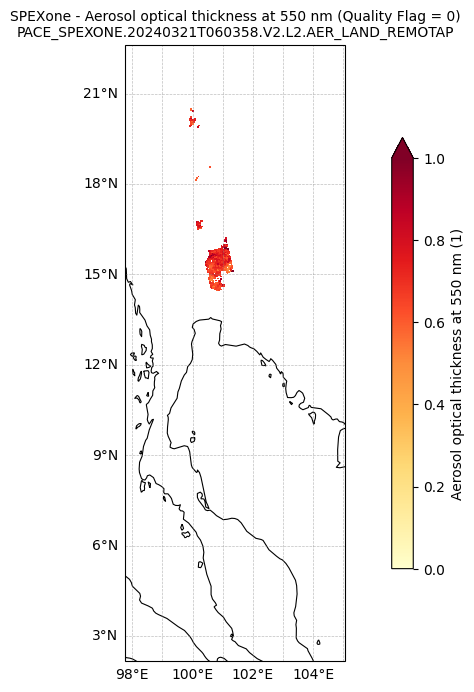

In [4]:
if data_loaded_successfully and map_extent_calculated and latitude_granule is not None:
    extent_padding_val = 1.0 
    map_extent_plot = [global_lon_min - extent_padding_val, global_lon_max + extent_padding_val, 
                       global_lat_min - extent_padding_val, global_lat_max + extent_padding_val]

    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    try:
        ax.set_extent(map_extent_plot, crs=ccrs.PlateCarree())
    except Exception as e:
        print(f"Error setting map extent {map_extent_plot}: {e}. Using global extent.")
        ax.set_global()
    
    ax.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    plotted_mesh_aod = None 
    aod_to_plot = aot550_qa_filtered_granule # This is the QA filtered data for the single granule

    if aod_to_plot.size > 0 and np.any(~np.isnan(aod_to_plot)):
        mesh = ax.pcolormesh(longitude_granule, latitude_granule, aod_to_plot, 
                             transform=ccrs.PlateCarree(), 
                             cmap='YlOrRd', 
                             vmin=0, 
                             vmax=1.0, 
                             shading='auto')
        plotted_mesh_aod = mesh
    
    aot550_display_long_name = var_attributes.get('AOT550_long_name', 'AOT at 550nm')
    aot550_display_units = var_attributes.get('AOT550_units', '1')
    title_str_prefix = f'SPEXone - {aot550_display_long_name} (Quality Flag = 0)'
    title_str_suffix = base_nc_filename_for_output # Already includes '.nc' stripped

    if plotted_mesh_aod is not None:
        cbar = plt.colorbar(plotted_mesh_aod, ax=ax, orientation='vertical', pad=0.05, shrink=0.7, extend='max')
        cbar.set_label(f"{aot550_display_long_name} ({aot550_display_units})")
        plt.title(f'{title_str_prefix}\n{title_str_suffix}', fontsize=10)
    else:
        print("No valid AOD data to plot for this file.")
        plt.title(f'{title_str_prefix}\nNo valid data in {title_str_suffix}', fontsize=10)
    
    save_filename_aod = f"{base_nc_filename_for_output}_AOT550_QF0.png"
    full_save_path_aod = os.path.join(output_image_dir, save_filename_aod)
    plt.savefig(full_save_path_aod, dpi=300, bbox_inches='tight') 
    print(f"AOD Map saved to: {full_save_path_aod}")
    plt.show() 
    plt.close(fig)
else:
    print("Skipping AOD map plotting: Data not loaded, map extent not calculated, or no plottable AOD data.")

## Step 5: Save Extracted Data to ASCII (CSV) File
Saves datetime, latitude, longitude, quality-filtered AOD (where QF=0), and the quality flag itself for all valid pixels from the single file.

In [5]:
if data_loaded_successfully and ascii_pixels_datetime:
    ascii_filename = f"{base_nc_filename_for_output}_pixel_data.csv"
    full_ascii_path = os.path.join(output_ascii_dir, ascii_filename)

    print(f"\nSaving valid pixel data to ASCII file: {full_ascii_path}")
    with open(full_ascii_path, 'w') as f:
        f.write("Datetime,Latitude,Longitude,AOT550_QF0,QualityFlag\n")
        
        for i in range(len(ascii_pixels_datetime)):
            dt_obj = ascii_pixels_datetime[i]
            lat_val = ascii_pixels_lat[i]
            lon_val = ascii_pixels_lon[i]
            aot_val = ascii_pixels_aot[i]
            qf_val = ascii_pixels_qf[i]
            
            dt_str = dt_obj.strftime('%Y-%m-%dT%H:%M:%S.%fZ') 
            f.write(f"{dt_str},{lat_val:.4f},{lon_val:.4f},{aot_val:.4f},{int(qf_val)}\n")
            
        print(f"Finished writing ASCII file. {len(ascii_pixels_datetime)} valid data points written.")
else:
    print("Skipping ASCII file generation: No valid data points were processed or data loading failed.")


Saving valid pixel data to ASCII file: ../output/ascii/PACE_SPEXONE.20240321T060358.V2.L2.AER_LAND_REMOTAP_pixel_data.csv
Finished writing ASCII file. 416 valid data points written.


## End of Processing

In [6]:
print("Individual NetCDF file was closed automatically after reading (using h5py.File with 'with' statement).")
print("--- SPEXone Single File Data Processing Complete ---")

Individual NetCDF file was closed automatically after reading (using h5py.File with 'with' statement).
--- SPEXone Single File Data Processing Complete ---
